###Commute Time vs Income

There have been many [theories](http://www.theatlantic.com/business/archive/2015/05/stranded-how-americas-failing-public-transportation-increases-inequality/393419/) surrounding this that poor people, with less cars, relies on public transportation which increases their commute time. Further evidence [suggests](http://scholar.harvard.edu/hendren/publications/impacts-neighborhoods-intergenerational-mobility-childhood-exposure-effects-and) that transportation mobility is linked to economic mobility. 


To explore this, I used the Census dataset from [Kaggle](www.kaggle.com) to do a simple analysis on the relationship between the commute time and wage for residence in Texas. I looked at the distributions and ran some simple tests to look at the differences of commute times between race and income groups.

In [1]:
%matplotlib inline

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, kruskal, mstats, pearsonr
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
from itertools import combinations
import warnings


ImportError: No module named statsmodels.stats.multitest

In [5]:
#use this file for subsequent analysis
data = pd.read_csv('/home/minh/portfolio/census/data.csv')

###Preprocessing and Cleaning Up

I downloaded the files from [Kaggle](www.kaggle.com) and randomly sample half a million because of size limitations. I, then, take only the variables of interested and remap the numeric variables into the string counterparts for readability. I also rescale and normalized the wages to take a look at the distribution for exploratory purposes.

In [6]:
#loading up data frame and subsetting it to Texas and variable of interests
dfa = pd.read_csv('/home/minh/portfolio/census/ss13pusa.csv')
dfb = pd.read_csv('/home/minh/portfolio/census/ss13pusb.csv')
df = dfa.append(dfb)

#randomly sample 500,000 people
rows = np.random.choice(df.index.values, 500000)
data  = df.loc[rows,['ST','WAGP','RAC1P','JWTR','JWMNP', 'INDP']]

#renaming columns
data = data.rename(columns = {
    'ST': 'state',
    'WAGP': 'wage',
    'RAC1P': 'race',
    'JWTR' : 'transportation'
    'JWMNP': 'commute',
    'INDP' : 'industry'
})
#save file 
data.to_csv('/home/minh/portfolio/census/data.csv') 

#removing missing data
data = data[np.isfinite(data['commute'])] 

#renaming the numeric code into strings
data['race'] = data['race'].astype('category')
race = {"White": [1], "Black": [2], "American or Alaskan Native": [3,4,5], "Asian/Pacific Islander": [6,7],
    "Other Race": [8], "Two or More Races": [9]}
race2 = {v: k for k,vv in race.items() for v in vv}
data['race'] = data['race'].map(race2).astype("category", categories = set(race2.values()))

#scaling data
data['commute'].describe()
data['wage'].describe()
data['wage_scaled'] = (data['wage'] - data['wage'].mean())/data['wage'].std()
data['wage_scaled'].describe()
data_scaled = data[(data['wage_scaled'] < 3) & (data['wage_scaled'] > -3)]
data_scaled['wage'].describe()
data_scaled.shape

###Plotting

I created some plots to look at the distributions of income and wages. I also created a scatterplot to visualize the interaction between commute time and income. The first one is just a straight scatter plot, the second emphasizes density, with the blue denoting less dense observations and red denoting very dense clustering

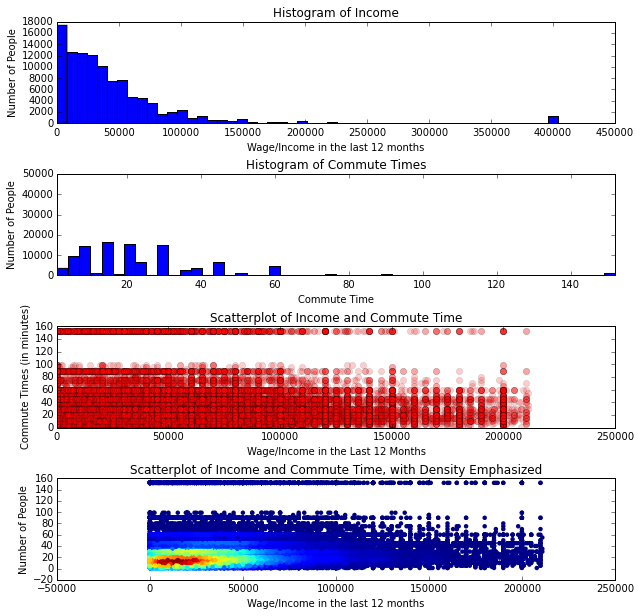

In [165]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize = (10,10))

#histogram of income
axes[0].hist(data['wage'].values, 50)
axes[0].set_xlabel('Wage/Income in the last 12 months')
axes[0].set_ylabel('Number of People')
axes[0].set_title('Histogram of Income')

#histogram of income
axes[1].hist(data['commute'].values, 50)
axes[1].set_xlabel('Commute Time')
axes[1].set_ylabel('Number of People')
axes[1].set_title('Histogram of Commute Times')
axes[1].axis([data['commute'].min(), data['commute'].max(), 0, 50000])

#scatterplot of income and commute time
axes[2].plot(data_scaled['wage'], data_scaled['commute'], 'ro', alpha = 0.2)
axes[2].set_xlabel('Wage/Income in the Last 12 Months')
axes[2].set_ylabel('Commute Times (in minutes)')
axes[2].set_title('Scatterplot of Income and Commute Time')

#scatter plot of income and commute time, with density emphasized.
#Redder indicates more people cluster in an area, while blue indicates less.
xy = np.vstack([data_scaled['wage'], data_scaled['commute']])
z = gaussian_kde(xy)(xy)
axes[3].scatter(data_scaled['wage'], data_scaled['commute'], c=z, edgecolor='')
axes[3].set_xlabel('Wage/Income in the last 12 months')
axes[3].set_ylabel('Number of People')
axes[3].set_title('Scatterplot of Income and Commute Time, with Density Emphasized')

fig.subplots_adjust(hspace=.5)
plt.show()


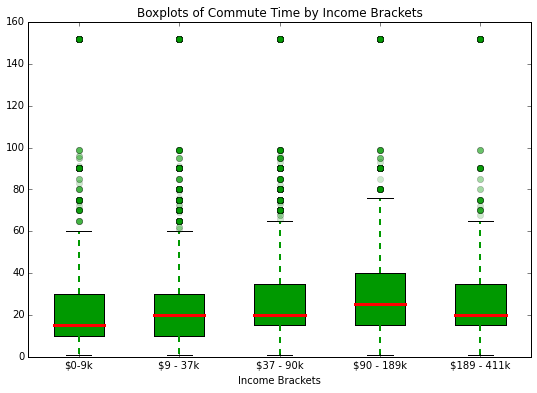

In [112]:
#creating the data to create boxplot
df1 = data.loc[data['income_group'] == 'lowest', 'commute']
df2 = data.loc[data['income_group'] == 'low', 'commute']
df3 = data.loc[data['income_group'] == 'middle', 'commute']
df4 = data.loc[data['income_group'] == 'high', 'commute']
df5 = data.loc[data['income_group'] == 'very high', 'commute']
to_plot = [df1, df2, df3, df4, df5]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(to_plot, patch_artist=True)

#change color of boxes
for box in bp['boxes']:
    box.set( facecolor = '#009900')

#change whiskers of plot
for whisker in bp['whiskers']:
    whisker.set(color='#009900', linewidth=2)
    
#change colors of outliers, decreasing opacity to see density
for flier in bp['fliers']:
    flier.set(marker='o', color='#009900', alpha=0.2)
    
#increase line width of median
for median in bp['medians']:
    median.set(color='#FF0000', linewidth=3)

#change x axis label
ax.set_xticklabels(['$0-9k', '$9 - 37k','$37 - 90k','$90 - 189k', '$189 - 411k', 'Over $411K'])
ax.set_xlabel('Income Brackets')
ax.set_title('Boxplots of Commute Time by Income Brackets')

plt.show()

###Income

I use [Bankrate](http://www.bankrate.com/finance/taxes/tax-brackets.aspx) to break down the wages into their respective groups. First used a Pearson's correlation to look at the direction of the relationship. Noting the results, I used the Kruskal-Wallace test, which is the nonparametic version of the ANOVA analysis since
the conditions of normality is not met given the distribution of commute times. After running the Kruskal test, I ran Nemenyi's multiple comparison test, which is the nonparametric version of Tukey's HSD test to examine which pairwise combination had a significant difference between different groups. 


In [5]:
#breaking income into US tax brackets according to the bankrate.com
data['income_group'] = pd.cut(data['wage'], bins = [0,9225,37450,90750,189300,411500],
                             labels = ['lowest', 'low', 'middle','high','very high'])

data['income_group'].value_counts()

#Run Pearson's correlation
pearsonr(data['wage'], data['commute'])

(0.090518490087742862, 2.0191466612338789e-192)

In [127]:
#creating the arrays for Kruskal
sample1 = data.loc[data['income_group'] == 'lowest', 'wage']
sample2 = data.loc[data['income_group'] == 'low', 'wage']
sample3 = data.loc[data['income_group'] == 'middle', 'wage']
sample4 = data.loc[data['income_group'] == 'high', 'wage']
sample5 = data.loc[data['income_group'] == 'very high', 'wage']

#Run the Kruskal-Wallace Test
kruskal(sample1,sample2,sample3, sample4, sample5)

(78850.311988762667, 0.0)

In [45]:
#load Nemenyi's multiple comparison test from a Gist snippet
%load https://gist.githubusercontent.com/alimuldal/21b4442b7e7f36f6a17b/raw/5e38c602a828893382c4c51b5a183260cc208603/nemenyi.py

#implement the test
kw_nemenyi([sample1, sample2, sample3, sample4, sample5])

(89037.469165531409,
 0.0,
 array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
         0.001,  0.001]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool))

#Rural vs. Urban Dwellers

I suspect that living in rural vs urban areas will have some variance, so I used the industry code as a proxy for
urban and rural dwelling and subsetted the data to only include people who live in "urban" areas. People who have an Industry code of less than 290 are usually agricultural or manufacturing jobs which I assume are more in rural areas.

Their job titles include crop production, hunting of animals, forestry, and logging which are more common in people in rural areas. This isn't a perfect proxy but since the Census dataset does not include density of the area of where people live or urban/rural flags, this is the best proxy I can think of 

In [118]:
#subsetting the data
data['area'] = np.where(data['industry'] <= 290, 'rural', 'urban')
data = data.loc[data['area'] == 'urban']

In [123]:
#creating arrays by breaking income into groups again
sample1 = data.loc[data['income_group'] == 'lowest', 'wage']
sample2 = data.loc[data['income_group'] == 'low', 'wage']
sample3 = data.loc[data['income_group'] == 'middle', 'wage']
sample4 = data.loc[data['income_group'] == 'high', 'wage']
sample5 = data.loc[data['income_group'] == 'very high', 'wage']

#Run Kruskal-Wallace tests, again
kruskal(sample1,sample2,sample3, sample4, sample5)

(78850.311988762667, 0.0)

In [126]:
#load Nemenyi's multiple comparison test, again
#%load https://gist.githubusercontent.com/alimuldal/21b4442b7e7f36f6a17b/raw/5e38c602a828893382c4c51b5a183260cc208603/nemenyi.py

kw_nemenyi([sample1, sample2, sample3, sample4, sample5])

(78850.311988762667,
 0.0,
 array([ 0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,  0.001,
         0.001,  0.001]),
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool))

#Race

I finally consider the differences in commute times by race, which I also suspect is confounded with income, but for the sake of this analysis I'll assume that they bear no relationship to each other. Maybe it'll be further part of my research if I consider going back and explore this topic a bit more in depth.

In [9]:
#creating arrays by breaking income into groups again
race1 = data.loc[data['race'] == 'White', 'wage']
race2 = data.loc[data['race'] == 'Black', 'wage']
race3 = data.loc[data['race'] == 'American or Alaskan Native', 'wage']
race4 = data.loc[data['race'] == 'Asian/Pacific Islander', 'wage']
race5 = data.loc[data['race'] == 'Other Race', 'wage']
race6 = data.loc[data['race'] == 'Two or More Races', 'wage']


#Run Kruskal-Wallace tests, again
kruskal(race1,race2, race3, race4, race5, race6)

(1476.5089953639729, 0.0)

In [13]:
#load Nemenyi's multiple comparison test, again
#%load https://gist.githubusercontent.com/alimuldal/21b4442b7e7f36f6a17b/raw/5e38c602a828893382c4c51b5a183260cc208603/nemenyi.py

kw_nemenyi([race1,race2,race3,race4,race5,race6])

(1476.5089953639729,
 0.0,
 array([ 0.001     ,  0.001     ,  0.001     ,  0.001     ,  0.001     ,
         0.67804175,  0.001     ,  0.001     ,  0.9       ,  0.001     ,
         0.0022035 ,  0.82833219,  0.001     ,  0.001     ,  0.001     ]),
 array([ True,  True,  True,  True,  True, False,  True,  True, False,
         True,  True, False,  True,  True,  True], dtype=bool))